In [1]:
import pandas as pd
import glob
import os
import json
import numpy as np
from  cycler import cycler
import fastplot
from collections import Counter, defaultdict
from statistics import mode
import re
import scipy.stats


CYCLER_LINESPOINTS=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]) +
                    cycler('marker', ['o', 's', 'v', 'd', '^' ]))

CYCLER_LINES=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]))


PLOT_ARGS = {"style":"latex", "grid":True, "figsize":(4.25,2.5), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

PLOT_ARGS_LARGE = {"style":"latex", "grid":True, "figsize":(9,2.75), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

BEFORE_STR = "\\emph{Before-Accept}"
AFTER_STR = "\\emph{After-Accept}"
ADDITIONAL_STR = "\\emph{Additional-Visits}"


TRANSLATE_CATEGORIES = {"Computers Electronics and Technology": "Computers and Technology",
                        "Business and Consumer Services": "Business and Services",
                        "Heavy Industry and Engineering": "Industry and Engineering"}

COUNTRY_TRAD={"it":"Italy", "fr":"France", "de":"Germany", "es":"Spain", "uk":"UK", "us": "US"}

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
trackers = set( open("trackers-list.txt", "r").read().splitlines() )

similarweb_websites=defaultdict(set)
for c in ["it", "es", "fr", "de", "uk", "us"]:
    similarweb_websites[c] = set(open("similarweb/{}.txt".format(c), "r" ).read().splitlines()) 
    

In [3]:
bad_domains=set("co.uk co.jp co.hu co.il com.au co.ve .co.in com.ec com.pk co.th co.nz com.br com.sg com.sa \
com.do co.za com.hk com.mx com.ly com.ua com.eg com.pe com.tr co.kr com.ng com.pe com.pk co.th \
com.au com.ph com.my com.tw com.ec com.kw co.in co.id com.com com.vn com.bd com.ar \
com.co com.vn org.uk net.gr".split())

def getGood2LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]    
    names = fqdn.split(".")
    if ".".join(names[-2:]) in bad_domains:
        return get3LD(fqdn)
    tln_array = names[-2:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

def get3LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    tln_array = names[-3:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

In [6]:
df = pd.read_csv("data/tranco-cold-cache.csv")

df["sld"] = df["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df["tld"] = df["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  ) 

In [7]:
for country in similarweb_websites:
    df[country] = (df.sld.isin(similarweb_websites[country])) | (df.tld.isin(similarweb_websites[country]))


In [8]:
similarweb_csv = pd.read_csv("similarweb/similarweb.csv")
similarweb_csv["category"] = similarweb_csv["category"].apply(lambda s: TRANSLATE_CATEGORIES[s] if s in TRANSLATE_CATEGORIES else s)

categories = defaultdict(set)

for row in similarweb_csv.itertuples():
    if row.category != "ALL" and row.country in {"it", "es", "fr", "de", "uk"} :
        categories[row.category].add(row.website)
        
for category in categories:
    df[category] = (df.sld.isin(categories[category])) | (df.tld.isin(categories[category]))


In [9]:
def get_trackers(s):
    d = json.loads(s)
    this_trackers = set()
    for c in d:
        if (c["domain"] in trackers or getGood2LD(c["domain"]) in trackers or get3LD(c["domain"]) in trackers) and c["expires"] > 0:
            this_trackers.add(getGood2LD(c["domain"]))
    return list(this_trackers)

df["trackers_first"] = df["cookie_first"].apply(get_trackers)
df["trackers_click"] = df["cookie_click"].apply(get_trackers)
df["trackers_internal"] = df["cookie_internal"].apply(get_trackers)

In [10]:
def website_stats(this_df):
    num = len(this_df.index)
    trackers_first = set()
    trackers_click = set()
    trackers_internal = set()
    
    trackers_first_all = set(this_df.iloc[0].trackers_first)
    trackers_click_all = set(this_df.iloc[0].trackers_click)
    trackers_internal_all = set(this_df.iloc[0].trackers_internal)

    has_found_banner = False
    
    tp_first = set()
    tp_click = set()
    
    countries = { c:False for c in similarweb_websites.keys()}
    cats = { c:False for c in categories.keys()}
    #+ list(similarweb_websites.keys()) + list(categories.keys())
    
    
    for i, row in this_df.iterrows():

        trackers_first |= set(row.trackers_first)
        trackers_click |= set(row.trackers_click)
        trackers_internal |= set(row.trackers_internal)
        
        trackers_first_all &= set(row.trackers_first)
        trackers_click_all &= set(row.trackers_click)
        trackers_internal_all &= set(row.trackers_internal)

        
        tp_first |= set([ getGood2LD(d) for d in json.loads(row.domains_first) if d != ""] )
        tp_click |= set([ getGood2LD(d) for d in json.loads(row.domains_click) if d != ""])      
        
        for c in list(similarweb_websites.keys()):
            countries[c] |= row[c]

        for c in list(categories.keys()):
            cats[c] |= row[c]
            
        if row.has_found_banner:
            has_found_banner=True
        
    trackers_only_click = trackers_click - trackers_first
       
    return pd.Series({"count": num,
                      "trackers_first": trackers_first,
                      "trackers_click": trackers_click,
                      "trackers_only_click": trackers_only_click,
                      "trackers_internal": trackers_internal,
                      
                      "trackers_first_all": trackers_first_all,
                      "trackers_click_all": trackers_click_all,
                      "trackers_internal_all": trackers_internal_all,
                    
                      "tp_first": tp_first,
                      "tp_click": tp_click,
                      "has_found_banner": has_found_banner,
                      "onload_first": this_df["onload_first"].median(),
                      "onload_second": this_df["onload_second"].median(),
                      "rum_first": this_df["rum_first"].mean(),
                      "rum_second": this_df["rum_second"].mean(),
                      "objects_first": this_df["objects_first"].mean(),
                      "objects_second": this_df["objects_second"].mean(),
                      "bytes_first": this_df["bytes_first"].median(),
                      "bytes_second": this_df["bytes_second"].median(),
                      "byte_index_first": this_df["byte_index_first"].mean(),
                      "object_index_first": this_df["object_index_first"].mean(),
                      "byte_index_second": this_df["byte_index_second"].mean(),
                      "object_index_second": this_df["object_index_second"].mean(),
                      **countries, **cats
                     })

grouped = df.groupby(["sld"] ).apply(website_stats).reset_index()

In [11]:
grouped["tp_first_nb"] = grouped["tp_first"].apply(len)
grouped["tp_click_nb"] = grouped["tp_click"].apply(len)

this_grouped =  grouped[(grouped["has_found_banner"]==True) & \
                        (grouped["onload_first"] > 0 ) & (grouped["rum_first"] > 0 ) & \
                        (grouped["bytes_first"] > 0)   & (grouped["objects_first"] > 0) ].copy()

this_grouped["onload_ratio"] = (this_grouped["onload_second"] - this_grouped["onload_first"])/this_grouped["onload_first"]
this_grouped["bytes_ratio"] = (this_grouped["bytes_second"] - this_grouped["bytes_first"])/this_grouped["bytes_first"]
this_grouped["objects_ratio"] = (this_grouped["objects_second"] - this_grouped["objects_first"])/this_grouped["objects_first"]
this_grouped["tp_ratio"] = (this_grouped["tp_click_nb"] - this_grouped["tp_first_nb"])/this_grouped["tp_first_nb"]

this_grouped["bytes_ratio"] = (this_grouped["bytes_second"])/this_grouped["bytes_first"]
this_grouped["objects_ratio"] = (this_grouped["objects_second"] )/this_grouped["objects_first"]


this_grouped["rum_ratio"] = (this_grouped["rum_second"] - this_grouped["rum_first"])/this_grouped["rum_first"]
this_grouped["byte_index_ratio"] = (this_grouped["byte_index_second"] - this_grouped["byte_index_first"])/this_grouped["byte_index_first"]
this_grouped["object_index_ratio"] = (this_grouped["object_index_second"] - this_grouped["object_index_first"])/this_grouped["object_index_first"]
print(len(this_grouped))

23589


<Figure size 640x480 with 0 Axes>

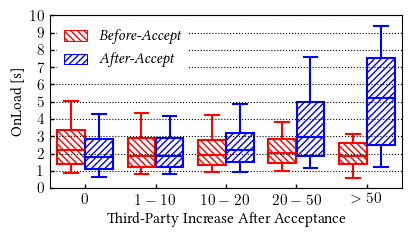

In [15]:
this_grouped_plot = this_grouped[ (this_grouped["bytes_first"]>0 ) & (this_grouped["onload_first"]<60000 ) & (this_grouped["onload_second"]<60000 )].copy()

this_grouped_plot["trackers_click_nb"] = this_grouped_plot["trackers_click"].apply(len)
this_grouped_plot["trackers_first_nb"] = this_grouped_plot["trackers_first"].apply(len)
this_grouped_plot["trackers_diff_nb"] = this_grouped_plot["trackers_click_nb"] - this_grouped_plot["trackers_first_nb"]
this_grouped_plot["tp_nb_diff"] = this_grouped_plot["tp_click_nb"] - this_grouped_plot["tp_first_nb"]

def get_bin(nb):
    if nb <=0:
        return "$0$"
    elif nb <=10:
        return "$1-10$"
    elif nb <=20:
        return "$10-20$"
    elif nb <=50:
        return "$20-50$"
    else:
        return "$>50$"

this_grouped_plot["bin"] = this_grouped_plot["tp_nb_diff"].apply(get_bin)

to_plot = this_grouped_plot.groupby("bin")[["onload_first", "onload_second"]].apply(lambda df: (df/1000).transpose().apply(list, axis=1))
to_plot = to_plot.rename(columns={"onload_first": BEFORE_STR, "onload_second": AFTER_STR})
to_plot = to_plot.reindex(["$0$", "$1-10$", "$10-20$", "$20-50$", "$>50$"])
#to_plot = to_plot.reindex(["$0$", "$1-5$", "$6-10$", "$11-20$", "$>20$"])

plot = fastplot.plot( to_plot ,None, 
               mode='boxplot_multi', ylabel = 'OnLoad [s]', xlabel = "Third-Party Increase After Acceptance",
               legend = True, legend_loc = "upper left",
               boxplot_whis=[10,90], ylim = (0,10), yticks = ([0,1,2,3,4,5,6,7,8,9,10], None), boxplot_palette="Set1",
               cycler = fastplot.CYCLER_LINES, 
               **PLOT_ARGS)

for p in plot.gca().artists[::2] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().artists[1::2]+ [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
    
for i in [ e for e in np.arange(len(to_plot.index)*10 ) if int(int(e/5) % 2) == 0]:
    plot.gca().lines[i].set_color ("red")
for i in [ e for e in np.arange(len(to_plot.index)*10 ) if int(int(e/5) % 2) == 1]:
    plot.gca().lines[i].set_color ("blue")
    
for i, n in enumerate(to_plot.applymap(len)[BEFORE_STR]):
    plot.text(i, 10.5, "~", ha="center", va="center")
    
plot.savefig("plots/cookieaccept_onload_by_tracker_tranco_cold_cache.pdf")
plot.show()